In [ ]:
#IST718 Group7 Project 

In [ ]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already isntalled
pip install pyspark &> /dev/null

In [ ]:
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F 
from pyspark import SparkConf
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

import pandas as pd
import numpy as np 
import matplotlib as plt
import matplotlib.pyplot as pyplot
import seaborn as sns
import ast, json
import glob
%matplotlib inline  

In [ ]:
spark = SparkSession.builder.master("local[2]").appName("airline").config("spark.some.config.option", "some-value").getOrCreate()
airline_df=spark.read.format('csv').option("header","true").load("airline_2019.csv")

In [ ]:
airline_df.show(5)

+--------+---------------------+--------+------+----------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
| FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST|DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|
+--------+---------------------+--------+------+----------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|2019/4/1|                20416|  N605NK

In [ ]:
# remove the null row
airline_df = airline_df.filter(airline_df.ARR_TIME. isNotNull()).filter(airline_df.CRS_ARR_TIME. isNotNull()).filter(airline_df.DEP_TIME. isNotNull()).filter(airline_df.CRS_DEP_TIME. isNotNull())
airline_df.count()

1022617

In [ ]:
#sample 20%
df=airline_df.sample(0.2,2022)
df.count()

204856

In [ ]:
# find which row contains delayed flights
from pyspark.sql.types import *
def target_normal(ARR_TIME,CRS_ARR_TIME):
    if float(ARR_TIME)-float(CRS_ARR_TIME)>0:
        return 1
    else:
        return 0
target_normal_udf = F.udf(lambda x,y:target_normal(x,y),IntegerType())
df_one=df.withColumn("zeroone", target_normal_udf(df["ARR_TIME"],df["CRS_ARR_TIME"]))

In [ ]:
# find which row contains delayed flights
from pyspark.sql.types import *
def target_normal(DEP_TIME,CRS_DEP_TIME):
    if float(DEP_TIME)-float(CRS_DEP_TIME)>0:
        return 1
    else:
        return 0
target_normal_udf = F.udf(lambda x,y:target_normal(x,y),IntegerType())
df_one_one=df_one.withColumn("dep_zeroone", target_normal_udf(df["DEP_TIME"],df["CRS_DEP_TIME"]))

In [ ]:
#remove rows that flights are not delayed when departing
df_one_one = df_one_one.where(df_one_one.dep_zeroone > 0)
df_one_one = df_one_one.where(df_one_one.zeroone > 0)
df_one_one.show(3)

+--------+---------------------+--------+------+-------------------+---------------+----+---------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-------+-----------+
| FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|   ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST| DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|zeroone|dep_zeroone|
+--------+---------------------+--------+------+-------------------+---------------+----+---------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-

In [ ]:
graph_df_one_one = df_one_one

In [ ]:
#compute the ARR_DELAY
from pyspark.sql.types import *
import time
import datetime
def target_normal2(ARR_TIME,CRS_ARR_TIME):
    try:
        ARR_TIME=str(int(float(ARR_TIME)))
        CRS_ARR_TIME=str(int(float(CRS_ARR_TIME)))
        h=time.strptime(ARR_TIME, "%H%M")
        h1=time.strptime(CRS_ARR_TIME, "%H%M")

        return (datetime.datetime(h[0],h[1],h[2],h[3],h[4])-datetime.datetime(h1[0],h1[1],h1[2],h1[3],h1[4])).seconds/60
    except:
        return None
    
target_normal_udf1 = F.udf(lambda x,y:target_normal2(x,y),FloatType())
graph_df_one_one=graph_df_one_one.withColumn("ARR_DELAY", target_normal_udf1(df["ARR_TIME"],df["CRS_ARR_TIME"]))




In [ ]:
#compute the DEP_DELAY
def target_normal3(DEP_TIME,CRS_DEP_TIME):
    try:
        DEP_TIME=str(int(float(DEP_TIME)))
        CRS_DEP_TIME=str(int(float(CRS_DEP_TIME)))
        h=time.strptime(DEP_TIME, "%H%M")
        h1=time.strptime(CRS_DEP_TIME, "%H%M")

        return (datetime.datetime(h[0],h[1],h[2],h[3],h[4])-datetime.datetime(h1[0],h1[1],h1[2],h1[3],h1[4])).seconds/60
    except:
        return None
    
target_normal_udf_g = F.udf(lambda x,y:target_normal3(x,y),FloatType())
graph_df_one_one = graph_df_one_one.withColumn("DEP_DELAY", target_normal_udf_g(df["DEP_TIME"],df["CRS_DEP_TIME"]))

In [ ]:
graph_panda_df = graph_df_one_one.toPandas()
arr_df = pd.read_csv("airline_2019.csv")
new_df = pd.concat([graph_panda_df["ARR_DELAY"], arr_df],axis = 1, join="inner")

In [ ]:
new_df2 = pd.concat([graph_panda_df["DEP_DELAY"], new_df],axis = 1, join="inner")

In [ ]:
new_df2.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


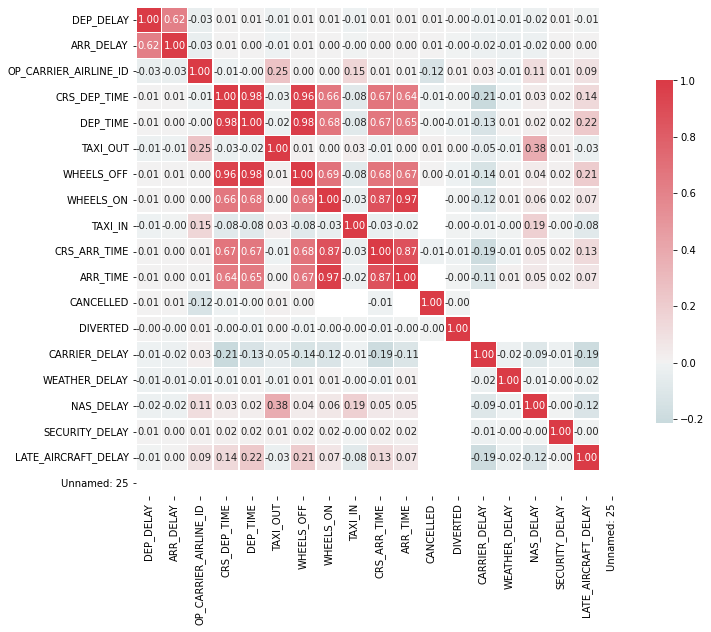

In [ ]:
def matrixCorr(df):
  corr = df.corr()

  # Generate a mask for the upper triangle
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  # Set up the matplotlib figure
  f, ax = plt.pyplot.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(210, 10, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, cmap=cmap, annot=True, vmax=1, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.7}, fmt='.2f')
  pyplot.show()

matrixCorr(new_df2)

In [ ]:
# NEW correlation grap
corr = new_df2.corr()
corr.style.background_gradient(cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,DEP_DELAY,ARR_DELAY,OP_CARRIER_AIRLINE_ID,CRS_DEP_TIME,DEP_TIME,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,CANCELLED,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 25
DEP_DELAY,1.000000,0.622743,-0.031864,0.006229,0.006237,-0.014567,0.007074,0.007443,-0.006934,0.008445,0.007470,0.006281,-0.000093,-0.012629,-0.014759,-0.019138,0.006852,-0.005044,nan
ARR_DELAY,0.622743,1.000000,-0.029715,0.005217,0.004623,-0.013542,0.005682,0.004829,-0.004648,0.001595,0.004191,0.005361,-0.001358,-0.016975,-0.014980,-0.021576,0.001057,0.001722,nan
OP_CARRIER_AIRLINE_ID,-0.031864,-0.029715,1.000000,-0.007594,-0.003815,0.251053,0.000449,0.002492,0.152437,0.011161,0.005095,-0.124269,0.010761,0.030387,-0.007087,0.109230,0.013848,0.086514,nan
CRS_DEP_TIME,0.006229,0.005217,-0.007594,1.000000,0.976234,-0.026101,0.956290,0.664745,-0.077215,0.673895,0.641595,-0.009109,-0.004077,-0.213649,-0.005508,0.033040,0.020165,0.140316,nan
DEP_TIME,0.006237,0.004623,-0.003815,0.976234,1.000000,-0.015924,0.977772,0.675421,-0.078539,0.672165,0.651890,-0.003486,-0.006026,-0.128794,0.005159,0.024162,0.016998,0.218284,nan
TAXI_OUT,-0.014567,-0.013542,0.251053,-0.026101,-0.015924,1.000000,0.010863,0.002645,0.026427,-0.005562,0.000520,0.010991,0.002167,-0.052433,-0.005706,0.376516,0.014022,-0.025369,nan
WHEELS_OFF,0.007074,0.005682,0.000449,0.956290,0.977772,0.010863,1.000000,0.690457,-0.076824,0.682398,0.666681,0.003302,-0.009766,-0.135508,0.005330,0.037530,0.017670,0.211624,nan
WHEELS_ON,0.007443,0.004829,0.002492,0.664745,0.675421,0.002645,0.690457,1.000000,-0.032613,0.867608,0.974042,nan,-0.001980,-0.118668,0.010965,0.059719,0.015192,0.069222,nan
TAXI_IN,-0.006934,-0.004648,0.152437,-0.077215,-0.078539,0.026427,-0.076824,-0.032613,1.000000,-0.025645,-0.020756,nan,-0.000698,-0.009855,-0.002096,0.187579,-0.004987,-0.076310,nan
CRS_ARR_TIME,0.008445,0.001595,0.011161,0.673895,0.672165,-0.005562,0.682398,0.867608,-0.025645,1.000000,0.869000,-0.007114,-0.005095,-0.186852,-0.005492,0.054961,0.019763,0.128233,nan


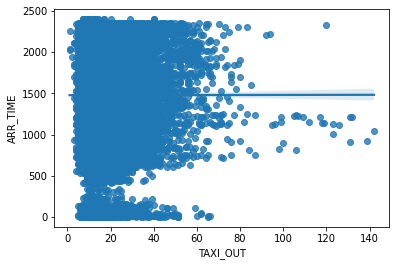

In [ ]:
sns.regplot(x=new_df2["TAXI_OUT"], y=new_df2["ARR_TIME"])
pyplot.show()

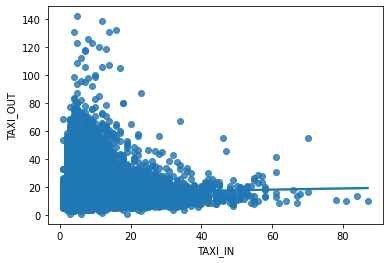

In [ ]:
sns.regplot(x=new_df2["TAXI_IN"], y=new_df2["TAXI_OUT"])
pyplot.show()

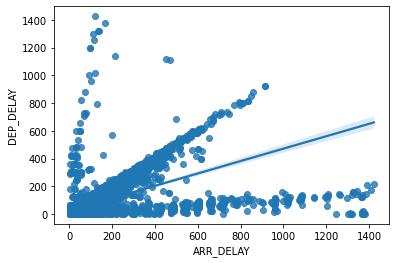

In [ ]:
sns.regplot(x=new_df2["ARR_DELAY"], y=new_df2["DEP_DELAY"])
pyplot.show()

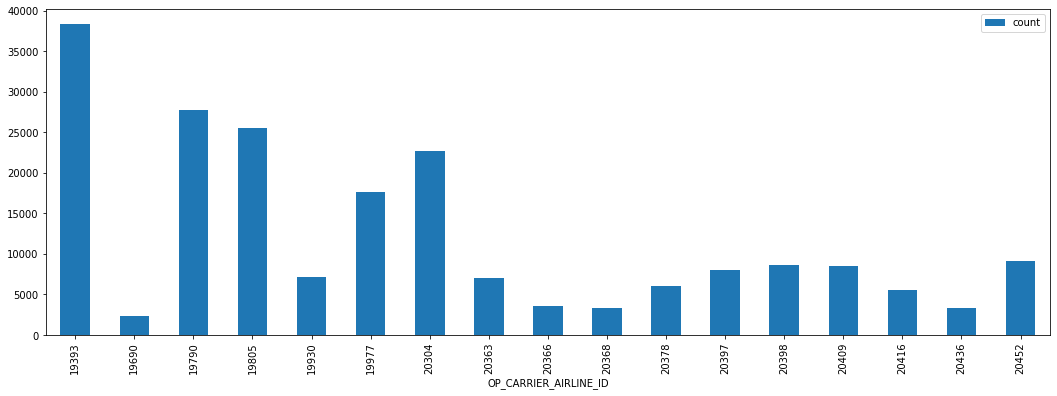

In [ ]:
df.groupBy("OP_CARRIER_AIRLINE_ID").count().sort("OP_CARRIER_AIRLINE_ID", ascending=True).toPandas().plot.bar(x='OP_CARRIER_AIRLINE_ID',figsize=(18, 6))

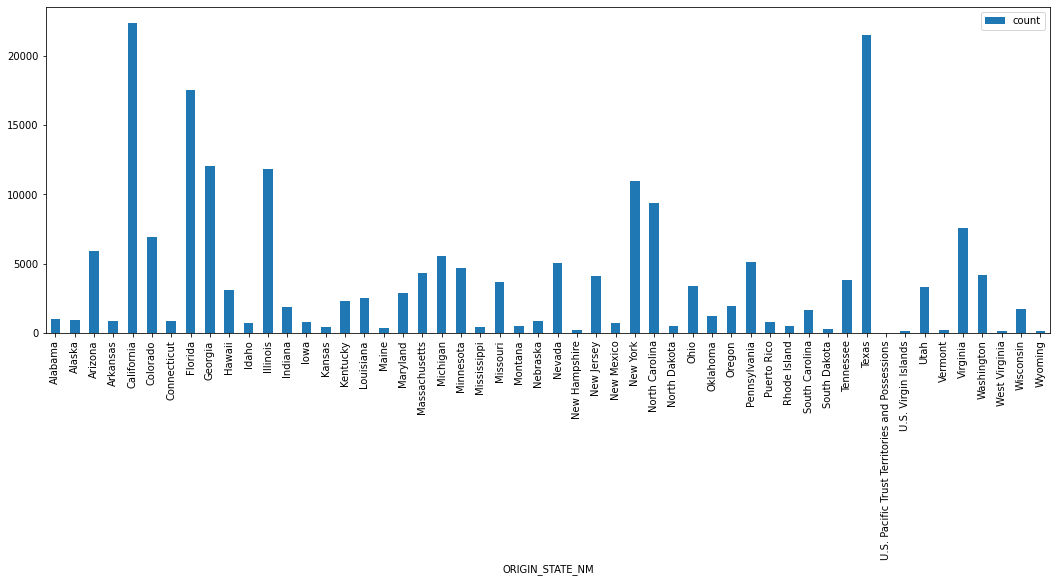

In [ ]:
df.groupBy("ORIGIN_STATE_NM").count().sort("ORIGIN_STATE_NM", ascending=True).toPandas().plot.bar(x='ORIGIN_STATE_NM',figsize=(18, 6))

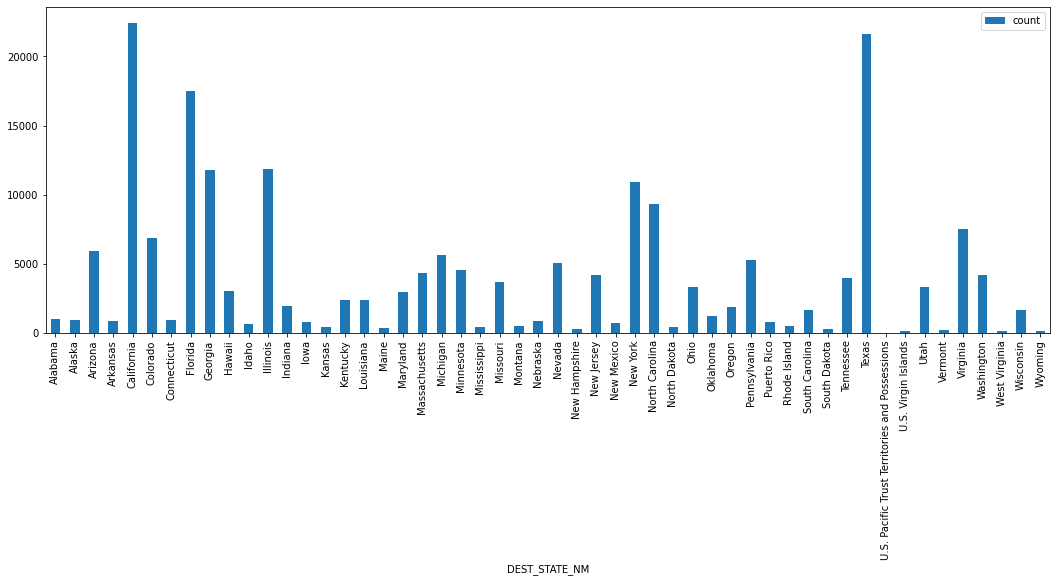

In [ ]:
df.groupBy("DEST_STATE_NM").count().sort("DEST_STATE_NM", ascending=True).toPandas().plot.bar(x='DEST_STATE_NM',figsize=(18, 6))

In [ ]:
###################################################################   ML Prediction Part #####################################################

In [ ]:
############################################### Below code is for Regression(Predict exact time a flight might delay)#######################################################


In [ ]:
#compute the DEP_DELAY
def target_normal3(DEP_TIME,CRS_DEP_TIME):
    try:
        DEP_TIME=str(int(float(DEP_TIME)))
        CRS_DEP_TIME=str(int(float(CRS_DEP_TIME)))
        h=time.strptime(DEP_TIME, "%H%M")
        h1=time.strptime(CRS_DEP_TIME, "%H%M")

        return (datetime.datetime(h[0],h[1],h[2],h[3],h[4])-datetime.datetime(h1[0],h1[1],h1[2],h1[3],h1[4])).seconds/60
    except:
        return None
    
target_normal_udf_g = F.udf(lambda x,y:target_normal3(x,y),FloatType())
df_one_one = df_one_one.withColumn("DEP_DELAY", target_normal_udf_g(df["DEP_TIME"],df["CRS_DEP_TIME"]))

In [ ]:

#compute the ARR_DELAY and name it label
from pyspark.sql.types import *
import time
import datetime
def target_normal2(ARR_TIME,CRS_ARR_TIME):
    try:
        ARR_TIME=str(int(float(ARR_TIME)))
        CRS_ARR_TIME=str(int(float(CRS_ARR_TIME)))
        h=time.strptime(ARR_TIME, "%H%M")
        h1=time.strptime(CRS_ARR_TIME, "%H%M")

        return (datetime.datetime(h[0],h[1],h[2],h[3],h[4])-datetime.datetime(h1[0],h1[1],h1[2],h1[3],h1[4])).seconds/60
    except:
        return None
    
target_normal_udf1 = F.udf(lambda x,y:target_normal2(x,y),FloatType())
df_one_one=df_one_one.withColumn("label", target_normal_udf1(df["ARR_TIME"],df["CRS_ARR_TIME"]))
df_one_one = df_one_one.filter(df_one_one.label.isNotNull())

In [ ]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col
df_one_one = df_one_one.withColumn("TAXI_OUT1", col("TAXI_OUT").cast(FloatType()))
df_one_one = df_one_one.drop('TAXI_OUT')
df_one_one = df_one_one.withColumn("TAXI_IN1", col("TAXI_IN").cast(FloatType()))
df_one_one = df_one_one.drop('TAXI_IN')
df_one_one = df_one_one.withColumn("CRS_ARR_TIME1", col("CRS_ARR_TIME").cast(FloatType()))
df_one_one = df_one_one.drop('CRS_ARR_TIME')
df_one_one = df_one_one.withColumn("ARR_TIME1", col("ARR_TIME").cast(FloatType()))
df_one_one = df_one_one.drop('ARR_TIME')
df_one_one = df_one_one.withColumn("DEP_DELAY1", col("DEP_DELAY").cast(FloatType()))
df_one_one = df_one_one.drop('DEP_DELAY')

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

def calcul(model,train,test):
    predictions_train = model.transform(train)
    predictions_test = model.transform(test)
    evaluator = RegressionEvaluator(
        metricName="mse")
    train_mse=evaluator.evaluate(predictions_train)
    test_mse=evaluator.evaluate(predictions_test)
    print('train MSE：', train_mse)
    print('test MSE：', test_mse)

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer = StringIndexer(inputCols=['OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_NM','DEST'
                                  ,'DEST_CITY_NAME','DEST_STATE_NM','TAXI_OUT1','TAXI_IN1','DEP_DELAY1','CRS_ARR_TIME1','ARR_TIME1'], 
                        outputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT1_index','TAXI_IN1_index','DEP_DELAY1_index','CRS_ARR_TIME1_index','ARR_TIME1_index'])

indexer.setHandleInvalid("keep")
encoder = OneHotEncoder(inputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT1_index','TAXI_IN1_index','DEP_DELAY1_index','CRS_ARR_TIME1_index','ARR_TIME1_index'],
                        outputCols=['OP_CARRIER_AIRLINE_ID_vec', 'TAIL_NUM_vec', 'ORIGIN_vec','ORIGIN_CITY_NAME_vec','ORIGIN_STATE_NM_vec','DEST_vec'
                                  ,'DEST_CITY_NAME_vec','DEST_STATE_NM_vec','TAXI_OUT1_vec','TAXI_IN1_vec','DEP_DELAY1_vec','CRS_ARR_TIME1_vec','ARR_TIME1_vec'])


In [ ]:
from pyspark.ml.feature import VectorAssembler
combine_vector = VectorAssembler(inputCols =['OP_CARRIER_AIRLINE_ID_vec', 'ORIGIN_vec','DEST_vec'
                                  ,'TAXI_OUT1_vec','TAXI_IN1_vec','CRS_ARR_TIME1_vec','ARR_TIME1_vec','DEP_DELAY1_vec'], 
                                   outputCol = 'features')

In [ ]:
df_one_one.show(5)

+--------+---------------------+--------+------+-------------------+---------------+----+--------------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-------+-----------+-----+----------+
| FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|   ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST|      DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|zeroone|dep_zeroone|label|DEP_DELAY1|
+--------+---------------------+--------+------+-------------------+---------------+----+--------------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-----------

In [ ]:
from pyspark.ml import Pipeline
feature_engineering_pipe = Pipeline(stages=[indexer,encoder,combine_vector])

In [ ]:
splits_reg = df_one_one.randomSplit([0.7, 0.3])
train_df_reg = splits_reg[0]
test_df_reg = splits_reg[1]

In [ ]:
feature_engineering_model=feature_engineering_pipe.fit(train_df_reg)

In [ ]:
train_df_feature=feature_engineering_model.transform(train_df_reg)
test_df_feature=feature_engineering_model.transform(test_df_reg)

In [ ]:
#Test Logistic Regression Model 
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

In [ ]:
lrModel = lr.fit(train_df_feature)

In [ ]:
calcul(lrModel,train_df_feature,test_df_feature)

train MSE： 597.9590693590733
test MSE： 2236.9409284091976


In [ ]:
#Test Decision Tree Model 
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dtModel=dt.fit(train_df_feature)

In [ ]:
calcul(dtModel,train_df_feature,test_df_feature)

train MSE： 7704.549459831495
test MSE： 8051.061497903592


In [ ]:
#Test Random Forest Model
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor()
rfModel=rf.fit(train_df_feature)

In [ ]:
calcul(rfModel,train_df_feature,test_df_feature)

train MSE： 7641.434293807262
test MSE： 7733.11937971359


In [ ]:
# Test Gradient Boosting Model 
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(maxIter=10)
gbtModel=gbt.fit(train_df_feature)

In [ ]:
calcul(gbtModel,train_df_feature,test_df_feature)

train MSE： 6534.220454110317
test MSE： 7327.115429227422


In [ ]:
#######################################################Below code is for Classification(Flight will or not delay)###########################################################

In [ ]:
# find which row contains delayed flights
from pyspark.sql.types import *
def target_normal(ARR_TIME,CRS_ARR_TIME):
    if float(ARR_TIME)-float(CRS_ARR_TIME)>0:
        return 1
    else:
        return 0
target_normal_udf = F.udf(lambda x,y:target_normal(x,y),IntegerType())
df_one_cla=df.withColumn("label", target_normal_udf(df["ARR_TIME"],df["CRS_ARR_TIME"]))

In [ ]:
# find which row contains delayed flights
from pyspark.sql.types import *
def target_normal(DEP_TIME,CRS_DEP_TIME):
    if float(DEP_TIME)-float(CRS_DEP_TIME)>0:
        return 1
    else:
        return 0
target_normal_udf = F.udf(lambda x,y:target_normal(x,y),IntegerType())
df_one_one_cla=df_one_cla.withColumn("dep_zeroone", target_normal_udf(df["DEP_TIME"],df["CRS_DEP_TIME"]))

In [ ]:
#remove rows that flights are not delayed when departing
df_one_one_cla = df_one_one_cla.where(df_one_one_cla.dep_zeroone > 0)
df_one_one_cla.show(3)

+--------+---------------------+--------+------+-------------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+-----------+
| FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|   ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST|DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|label|dep_zeroone|
+--------+---------------------+--------+------+-------------------+---------------+----+--------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+--------

In [ ]:
#compute the DEP_DELAY
def target_normal3(DEP_TIME,CRS_DEP_TIME):
    try:
        DEP_TIME=str(int(float(DEP_TIME)))
        CRS_DEP_TIME=str(int(float(CRS_DEP_TIME)))
        h=time.strptime(DEP_TIME, "%H%M")
        h1=time.strptime(CRS_DEP_TIME, "%H%M")

        return (datetime.datetime(h[0],h[1],h[2],h[3],h[4])-datetime.datetime(h1[0],h1[1],h1[2],h1[3],h1[4])).seconds/60
    except:
        return None
    
target_normal_udf_g = F.udf(lambda x,y:target_normal3(x,y),FloatType())
df_one_one_cla = df_one_one_cla.withColumn("DEP_DELAY", target_normal_udf_g(df["DEP_TIME"],df["CRS_DEP_TIME"]))

In [ ]:
df_one_one_cla.show()

+--------+---------------------+--------+------+-------------------+---------------+----+--------------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+-----------+---------+
| FL_DATE|OP_CARRIER_AIRLINE_ID|TAIL_NUM|ORIGIN|   ORIGIN_CITY_NAME|ORIGIN_STATE_NM|DEST|      DEST_CITY_NAME|DEST_STATE_NM|CRS_DEP_TIME|DEP_TIME|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|CANCELLED|CANCELLATION_CODE|DIVERTED|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 25|label|dep_zeroone|DEP_DELAY|
+--------+---------------------+--------+------+-------------------+---------------+----+--------------------+-------------+------------+--------+--------+----------+---------+-------+------------+--------+---------+-----------------+--------+-------------+-------------+---------+-----

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
def calcul2(model,train,test):
    predictions_train = model.transform(train)
    predictions_test = model.transform(test)
    evaluator = BinaryClassificationEvaluator()
    print('train AUC：', evaluator.evaluate(predictions_train))
    print('test AUC：', evaluator.evaluate(predictions_test))

In [ ]:
df_one_one_cla = df_one_one_cla.filter(df_one_one_cla.label. isNotNull())
df_one_one_cla.count()

68473

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder, StringIndexer
indexer = StringIndexer(inputCols=['OP_CARRIER_AIRLINE_ID', 'TAIL_NUM', 'ORIGIN','ORIGIN_CITY_NAME','ORIGIN_STATE_NM','DEST'
                                  ,'DEST_CITY_NAME','DEST_STATE_NM','TAXI_OUT','TAXI_IN','DEP_DELAY','CRS_ARR_TIME','ARR_TIME'], 
                        outputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT_index','TAXI_IN_index','DEP_DELAY_index','CRS_ARR_TIME_index','ARR_TIME_index'])
# indexed = indexer.fit(df).transform(df)
# indexed.show(3)
# indexer.setHandleInvalid("skip")
indexer.setHandleInvalid("keep")
encoder = OneHotEncoder(inputCols=['OP_CARRIER_AIRLINE_ID_index', 'TAIL_NUM_index', 'ORIGIN_index','ORIGIN_CITY_NAME_index','ORIGIN_STATE_NM_index','DEST_index'
                                  ,'DEST_CITY_NAME_index','DEST_STATE_NM_index','TAXI_OUT_index','TAXI_IN_index','DEP_DELAY_index','CRS_ARR_TIME_index','ARR_TIME_index'],
                        outputCols=['OP_CARRIER_AIRLINE_ID_vec', 'TAIL_NUM_vec', 'ORIGIN_vec','ORIGIN_CITY_NAME_vec','ORIGIN_STATE_NM_vec','DEST_vec'
                                  ,'DEST_CITY_NAME_vec','DEST_STATE_NM_vec','TAXI_OUT_vec','TAXI_IN_vec','DEP_DELAY_vec','CRS_ARR_TIME_vec','ARR_TIME_vec'])
# model = encoder.fit(indexed)
# encoded_df = model.transform(indexed)
# encoded_df.show(3)

In [ ]:
from pyspark.ml.feature import VectorAssembler
combine_vector = VectorAssembler(inputCols =['OP_CARRIER_AIRLINE_ID_vec', 'ORIGIN_vec','DEST_vec'
                                  ,'TAXI_OUT_vec','TAXI_IN_vec','CRS_ARR_TIME_vec','ARR_TIME_vec','DEP_DELAY_vec'], 
                                   outputCol = 'features')

In [ ]:
feature_engineering_pipe2 = Pipeline(stages=[indexer,encoder,combine_vector])

In [ ]:
#Split into Train and Test 
splits2 = df_one_one_cla.randomSplit([0.7, 0.3])
train_df2 = splits2[0]
test_df2 = splits2[1]

In [ ]:
feature_engineering_model2=feature_engineering_pipe2.fit(train_df2)

In [ ]:
train_df_feature2=feature_engineering_model2.transform(train_df2)
test_df_feature2=feature_engineering_model2.transform(test_df2)

In [ ]:
#test the performance of logistic regression model
from pyspark.ml.classification import LogisticRegression
lr2 = LogisticRegression()

In [ ]:
lrModel2 = lr2.fit(train_df_feature2)

In [ ]:
calcul2(lrModel2,train_df_feature2,test_df_feature2)

train AUC： 0.9997474978748734
test AUC： 0.9701231282033678


In [ ]:
#test the performance of Decision Tree model
from pyspark.ml.classification import DecisionTreeClassifier
dt2 = DecisionTreeClassifier()
dtModel2=dt2.fit(train_df_feature2)

In [ ]:
calcul2(dtModel2,train_df_feature2,test_df_feature2)

train AUC： 0.704639637037889
test AUC： 0.7061599042197053


In [ ]:
#Test the performance of Randoom Forest
from pyspark.ml.classification import RandomForestClassifier
rf2 = RandomForestClassifier()
rfModel2=rf2.fit(train_df_feature2)

In [ ]:
calcul2(rfModel2,train_df_feature2,test_df_feature2)

train AUC： 0.7734140855247452
test AUC： 0.7671954588641292


In [ ]:
#Test the performance of Gradient Boosting Model
from pyspark.ml.classification import GBTClassifier
gbt2 = GBTClassifier()
gbtModel2=gbt2.fit(train_df_feature2)

In [ ]:
calcul2(gbtModel2,train_df_feature2,test_df_feature2)

train AUC： 0.8404679684109343
test AUC： 0.8313686307166334
